In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

For this clustering I will only be dealing with a subset of the original data as the original data is huge and it will cause a memory error if used with CPU.

In [3]:
## load data
products = pd.read_csv('../cproducts.csv')

In [4]:
products.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
0,BBID_20482,1975-10-20,male,MADHYA PRADESH,453441.0,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,NONPROMO,NaN,1000446431,PATANJALI CHOCOS 125g,55.00,Payback
1,BBID_20485,1955-07-21,female,NaN,999999.0,2017-03-09,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,NONPROMO,NaN,1000010431,SOO FRESH ROLLS HOT DOG 4P,30.00,Payback
2,BBID_20498,1981-03-19,female,MAHARASHTRA,400064.0,2015-08-12,2655,BB-INDORE-MALHAR MEGA MALL,13,1064,0000971754,AD 399 FLAT LADIES JEANS FASHION EXC,1000077851005,"DLJ-0010-BSF-2-CJ-FL, 34, BLACK",418.95,Payback
3,BBID_20499,1986-05-10,male,MAHARASHTRA,400099.0,2016-12-18,2615,BB-AMRITSAR-TRILIUM MALL,14,51080,NONPROMO,NaN,1000443231,PATANJALI TOMATO KETCHUP BT 500g,70.00,Payback
4,BBID_204110,1988-02-29,male,MADHYA PRADESH,474001.0,2015-12-31,2655,BB-INDORE-MALHAR MEGA MALL,9,21911,0000974126,NMP 5% OFF CONCEPT DISCOUNT 2655,300481741,MAGGI NDL MERI MASALA PP 70g,34.20,Payback


In [5]:
## fill missing values

products['promotion_description'].fillna('no_promo', inplace=True)
products['Gender'].fillna('no_gender', inplace=True)
products['State'].fillna('no_state', inplace=True)
products['PinCode'].fillna(-1, inplace=True)
products['DOB'].fillna("1", inplace=True)

Many states are occuring multiple times due to misspelling, extra space, short form or case sensitivity. So I made this dictionary to convert them to one value per state.

In [6]:
state_dict = {'MADHY PRADESH':'MADHYA PRADESH', 'TAMILNADU':'TAMIL NADU', 'MADHYA  PRADESH':'MADHYA PRADESH', 'HARAYANA':'HARYANA',
             'Jharkhand':'JHARKHAND','Tamilnadu':'TAMIL NADU','Tamil Nadu':'TAMIL NADU','Madhya Pradesh':'MADHYA PRADESH',
             'REST OF WEST BENGAL':'WEST BENGAL', 'west bengal':'WEST BENGAL','Uttar Pradesh':'UTTAR PRADESH', 'Delhi':'DELHI',
             'Bhopal':'BHOPAL','CHHATISGARH':'CHHATTISGARH','CHATTISGARH':'CHHATTISGARH', 'jharkhand':'JHARKHAND','Chandigarh':'CHANDIGARH',
             'UTTAR PRADESH WEST': 'UTTAR PRADESH','ODISHA':'ORISSA','MAHARASTRA':'MAHARASHTRA','madhya pradesh':'MADHYA PRADESH',
             'KARNATAK':'KARNATAKA','JAMMU and KASHMIR':'JAMMU AND KASHMIR','JAMMU KASHMIR':'JAMMU AND KASHMIR','Rajasthan':'RAJASTHAN',
             'east singhbhum':'JHARKHAND', 'ORRISA':'ORISSA','Andhra Pradesh':'ANDHRA PRADESH', 'UTTARANCHAL':'UTTARAKHAND',
             'Uttar pradesh':'UTTAR PRADESH','Maharashtra':'MAHARASHTRA','MP':'MADHYA PRADESH', 'UTTAR PRADESH EAST':'UTTAR PRADESH',
             'Punjab':'PUNJAB','maharashtra':'MAHARASHTRA','Karnataka':'KARNATAKA','M.P.':'MADHYA PRADESH','DAMAN':'DAMAN AND DIU',
             'HUBLI':'KARNATAKA','Tamil nadu':'TAMIL NADU','GUJRAT':'GUJARAT', 'Mp':'MADHYA PRADESH','Madhya pradesh':'MADHYA PRADESH',
             'West Bengal':'WEST BENGAL','Gujarat':'GUJARAT','UP':'UTTAR PRADESH','Chennai':'CHENNAI', 'm.p.':'MADHYA PRADESH',
             'kerala':'KERALA'}

products.replace({"State": state_dict}, inplace=True)

In [7]:
## convert data into numeric / float

for c in products.columns:
    lbl = LabelEncoder()
    if products[c].dtype == 'object' and c not in ['store_description','customerID','transactionDate']:
        #products[c] = products[c].factorize()[0]
        products[c] = lbl.fit_transform(products[c])

In [8]:
#saving these variables to be used in making the final prediction
customers = products['customerID']
store_codes = products['store_code']

In [9]:
products_new = products.drop('customerID', axis=1, inplace=True)
products_new = products.drop('transactionDate', axis=1, inplace=True)
products_new = products.drop('store_description', axis=1)

In [10]:
products_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 13 columns):
DOB                           11972 non-null int64
Gender                        11972 non-null int64
State                         11972 non-null int64
PinCode                       11972 non-null float64
store_code                    11972 non-null int64
till_no                       11972 non-null int64
transaction_number_by_till    11972 non-null int64
promo_code                    11972 non-null int64
promotion_description         11972 non-null int64
product_code                  11972 non-null int64
product_description           11972 non-null int64
sale_price_after_promo        11972 non-null float64
discountUsed                  11972 non-null int64
dtypes: float64(2), int64(11)
memory usage: 1.2 MB


In [11]:
products_new = products_new['State']

In [12]:
#One hot encode the states
products_new = pd.get_dummies(products_new, columns='State', prefix='State')

In [13]:
products_new.head()

,State_0,State_1,State_2,State_3,State_4,State_5,State_6,State_7,State_8,State_9,...,State_20,State_21,State_22,State_23,State_24,State_25,State_26,State_27,State_28,State_29
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Implementation: Selecting Samples

To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, we will add three indices of our choice to the indices list which will represent the customers to track. It is suggested to try different sets of samples until we obtain customers that vary significantly from one another.

Chosen samples of wholesale customers dataset:


,State_0,State_1,State_2,State_3,State_4,State_5,State_6,State_7,State_8,State_9,...,State_20,State_21,State_22,State_23,State_24,State_25,State_26,State_27,State_28,State_29
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


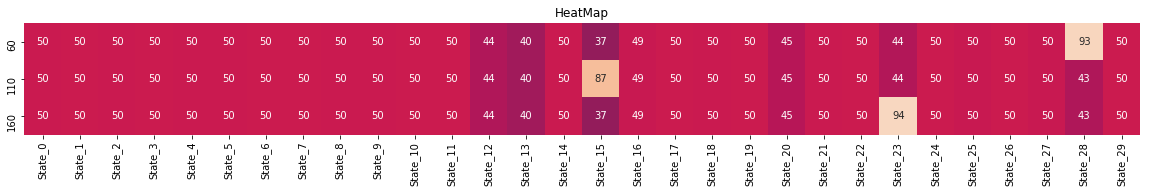

In [14]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [60,110,160]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(products_new.loc[indices], columns = products_new.keys()).reset_index(drop = True)
print ("Chosen samples of wholesale customers dataset:")
display(samples)


percentiles = products_new.rank(pct=True)
percentiles = 100*percentiles.round(decimals=3)
percentiles = percentiles.iloc[indices]

plt.figure(figsize=(20,10))
plt.axes().set_title("HeatMap")
sns.heatmap(percentiles, vmin=1, vmax=99, annot=True, cbar=False, square=True)

# Feature Transformation

In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

# Implementation: PCA

We can now apply PCA to the good_data to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.
In the code block below, we will need to implement the following:

1. Import sklearn.decomposition.PCA and assign the results of fitting PCA in 6 dimensions with products_new to pca.

2. Apply a PCA transformation of samples using pca.transform, and assign the results to pca_samples.

Dimension 1    0.2774
Dimension 2    0.4828
Dimension 3    0.6396
Dimension 4    0.7880
Dimension 5    0.9098
Dimension 6    0.9327
Name: Explained Variance, dtype: float64


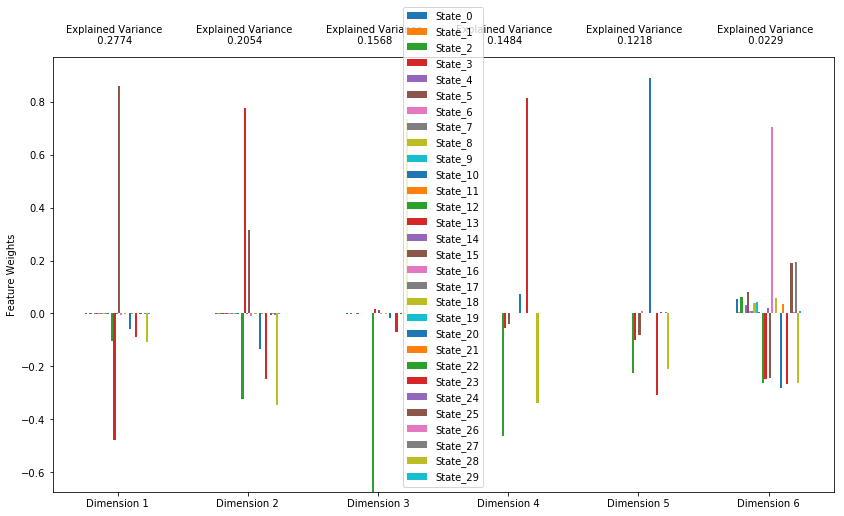

In [15]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=6).fit(products_new)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(products_new)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(samples)

# Create a DataFrame for the reduced data
#reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

pca_results = vs.pca_results(products_new, pca)

print(pca_results['Explained Variance'].cumsum())

We see that by the time we reach dimension 5, it is already explaining about 90% variance in the data. So we will go with 5 dimensions.

,Explained Variance,State_0,State_1,State_2,State_3,State_4,State_5,State_6,State_7,State_8,...,State_20,State_21,State_22,State_23,State_24,State_25,State_26,State_27,State_28,State_29
Dimension 1,0.2774,-0.0013,-0.0001,-0.0015,-0.0001,-0.0008,-0.0018,-0.0003,-0.0003,-0.0010,...,-0.0579,-0.0009,-0.0000,-0.0884,-0.0000,-0.0032,-0.0001,-0.0032,-0.1076,-0.0003
Dimension 2,0.2054,-0.0023,-0.0003,-0.0025,-0.0002,-0.0014,-0.0031,-0.0005,-0.0005,-0.0018,...,-0.1329,-0.0016,-0.0001,-0.2463,-0.0001,-0.0056,-0.0002,-0.0056,-0.3460,-0.0005
Dimension 3,0.1568,-0.0002,-0.0000,-0.0002,-0.0000,-0.0001,-0.0002,-0.0000,-0.0000,-0.0001,...,-0.0169,-0.0001,-0.0000,-0.0718,-0.0000,-0.0004,-0.0000,-0.0004,0.7352,-0.0000
Dimension 4,0.1484,0.0006,0.0001,0.0007,0.0000,0.0004,0.0009,0.0001,0.0001,0.0005,...,0.0736,0.0005,0.0000,0.8130,0.0000,0.0016,0.0001,0.0016,-0.3399,0.0001
Dimension 5,0.1218,0.0018,0.0002,0.0020,0.0001,0.0011,0.0025,0.0004,0.0004,0.0014,...,0.8907,0.0013,0.0000,-0.3077,0.0000,0.0046,0.0002,0.0046,-0.2116,0.0004


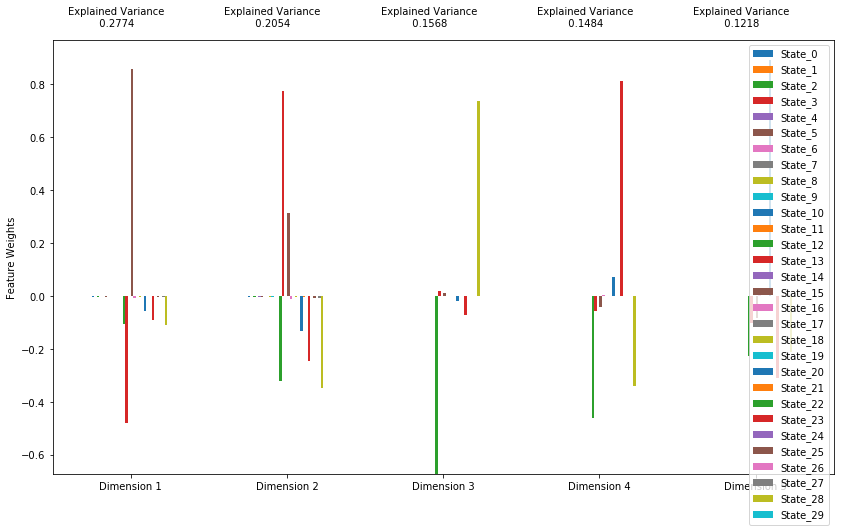

In [16]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=5).fit(products_new)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(products_new)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5'])

vs.pca_results(products_new, pca)

In [17]:
# Display sample data after applying PCA transformation in 5 dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4', 'Dimension 5']))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5
0,-0.1888,-0.4496,0.7291,-0.3190,-0.1630
1,0.7779,0.2107,0.0063,-0.0197,-0.0321
2,-0.1696,-0.3498,-0.0779,0.8340,-0.2591


# Creating clusters

GMM is a lot more flexible in terms of cluster covariance. K-means is actually a special case of GMM in which each cluster’s covariance along all dimensions approaches 0. This implies that a point will get assigned only to the cluster closest to it. With GMM, each cluster can have unconstrained covariance structure. Think of rotated and/or elongated distribution of points in a cluster, instead of spherical as in K-means. As a result, cluster assignment is much more flexible in GMM than in K-means.

# Implementation: Creating Clusters

Depending on the problem, the number of clusters that we expect to be in the data may already be known. When the number of clusters is not known a priori, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the mean silhouette coefficient provides for a simple scoring method of a given clustering.

In [18]:
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score

def silhouette(k):
    global clusterer, preds, centers, sample_preds
    
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=k, random_state=0)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_ 
    
    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    return score, preds

results = pd.DataFrame(columns=['Silhouette Score'])
results.columns.name = 'Number of Clusters'    
for k in range(2,16):
    score,_ = silhouette(k) 
    results = results.append(pd.DataFrame([score],columns=['Silhouette Score'],index=[k]))

display(results)

Number of Clusters,Silhouette Score
2,0.352465
3,0.490527
4,0.635809
5,0.769616
6,0.936096
7,0.999633
8,0.981448
9,0.991204
10,0.986507
11,0.987756


So we see that when the number of clusters is 7, we are getting the best silhouette score of 0.999633. So we will be using that.

# Cluster Visualization

Once we've chosen the optimal number of clusters for our clustering algorithm using the scoring metric above, we can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters.

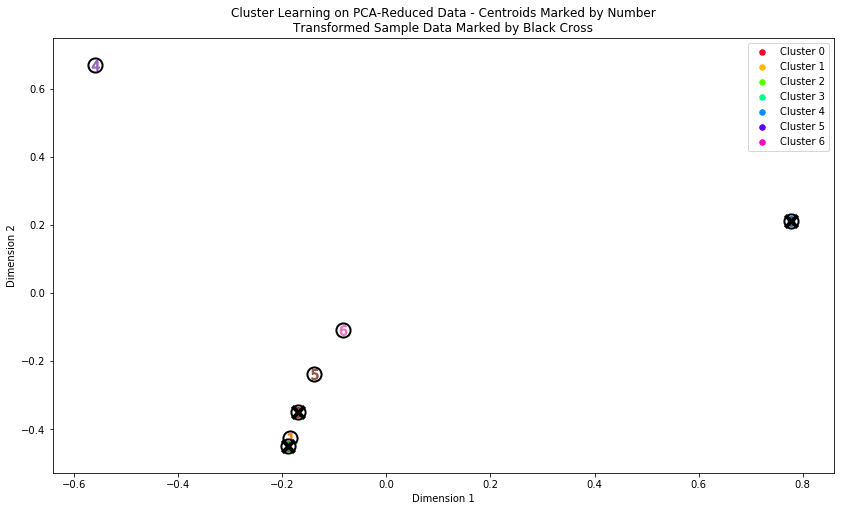

In [19]:
#Optimum silhouette score
scores, preds = silhouette(7)

# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

# Implementation: Data Recovery

Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the averages of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to the average customer of that segment.

In [20]:
# Display the true centers

segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(centers), columns = reduced_data.keys())
true_centers.index = segments
display(true_centers)

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5
Segment 0,1.0,0.0,0.0,-0.0,-0.0
Segment 1,-0.0,-0.0,-1.0,-0.0,-0.0
Segment 2,-0.0,-0.0,1.0,-0.0,-0.0
Segment 3,-0.0,-0.0,-0.0,1.0,-0.0
Segment 4,-1.0,1.0,0.0,-0.0,-0.0
Segment 5,-0.0,-0.0,-0.0,0.0,1.0
Segment 6,-0.0,-0.0,-0.0,0.0,0.0


** Let's see which clusters our sample points belong to! **

In [21]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print ("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 2
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 3


In [24]:
## create prediction dataframe
pred_df = pd.DataFrame({'customerID':customers, 'store_code':store_codes, 'cluster':preds}).reindex(columns=["customerID","store_code","cluster"])

In [25]:
#This is our final prediction.
pred_df.head()

,customerID,store_code,cluster
0,BBID_20482,2655,0
1,BBID_20485,2655,2
2,BBID_20498,2655,6
3,BBID_20499,2615,6
4,BBID_204110,2655,0


In [27]:
#And the reduced data
reduced_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5
0,0.777917,0.210705,0.006344,-0.019692,-0.032088
1,-0.188782,-0.449564,0.729121,-0.318955,-0.162954
2,-0.086602,-0.113091,-0.006803,0.023752,0.056735
3,-0.086602,-0.113091,-0.006803,0.023752,0.056735
4,0.777917,0.210705,0.006344,-0.019692,-0.032088
